In [17]:
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
import aplpy
from astropy.wcs import WCS

from astropy.wcs.utils import proj_plane_pixel_scales
from PIL import Image
import copy
import pickle

In [32]:
fpath = "/home/filament/Documents/gakkai/l_p0_p60_b_p10_p70_CAR.fits"
hdu = fits.open(fpath)[0]
w = WCS(hdu)

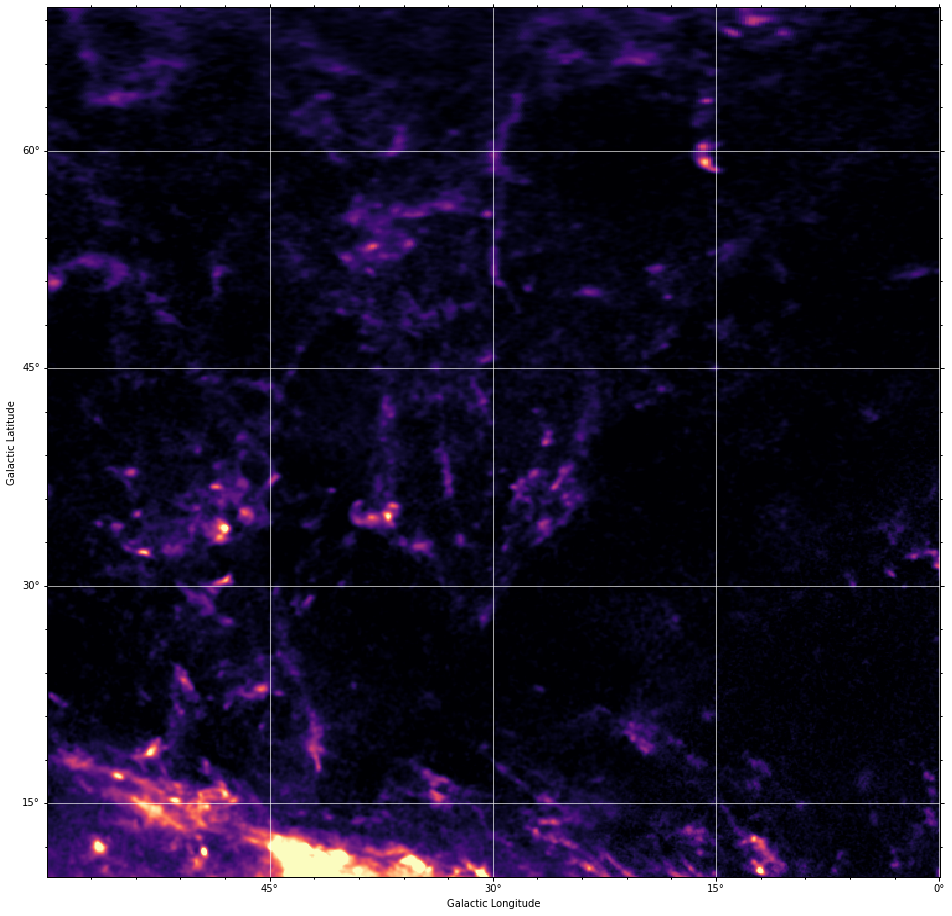

In [33]:

fig = plt.figure(figsize = (16,16))
f = aplpy.FITSFigure(hdu,figure = fig,slices=[430])
f.show_colorscale(vmin=0,vmax=2,cmap='magma',stretch='linear',exponent=0.5,aspect="auto")
# f.recenter(25,-20,width=25,height=120)
f.add_grid()
f.grid.set_color("w")
plt.show()

In [34]:
def xyv2ch(x, y, v, w):#km/s
    x_ch, y_ch, v_ch   = w.wcs_world2pix(x, y, v*1000.0, 0)
    x_ch = int(round(float(x_ch), 0))
    y_ch = int(round(float(y_ch), 0))
    v_ch = int(round(float(v_ch), 0))
    return x_ch, y_ch, v_ch

def xy2ch(x, y, w):
    x_ch, y_ch   = w.wcs_world2pix(x, y, 0)
    x_ch = int(round(float(x_ch), 0))
    y_ch = int(round(float(y_ch), 0))
    return x_ch, y_ch

def v2ch(v, w):#km/s
    x_tempo, y_tempo, v_tempo   = w.wcs_world2pix(0, 0, 0, 0)
    x_ch, y_ch, v_ch   = w.wcs_world2pix(x_tempo, y_tempo, v*1000.0, 0)
    v_ch = int(round(float(v_ch), 0))
    return v_ch

def ch2v(ch, w):#km/s
    x, y, v   = w.wcs_pix2world(0, 0, ch, 0)
    return v/1000.0

def del_header_key(header, keys): # headerのkeyを消す
    import copy
    h = copy.deepcopy(header)
    for k in keys:
        try:
            del h[k]
        except:
            pass
    return h

def make_new_hdu_integ_ch(hdu, v_start_ch, v_end_ch, w): # 積分強度のhduを作る
    data = hdu.data
    header = hdu.header
    new_data = np.nansum(data[v_start_ch:v_end_ch], axis=0)*header["CDELT3"]/1000.0
    header = del_header_key(header, ["CRVAL3", "CRPIX3", "CRVAL3", "CDELT3", "CUNIT3", "CTYPE3", "CROTA3", "NAXIS3"])
    header["NAXIS"] = 2
    header["WCSAXES"] = 2
    new_hdu = fits.PrimaryHDU(new_data, header)
    return new_hdu

def xy_cut(fits_name, x_start, x_end, y_start, y_end):
    from astropy.io import fits
    from astropy.wcs import WCS

    save_name = fits_name[:-5]+".xy_cut.fits"
    hdu = fits.open(fits_name)
    h = hdu[0].header
    d = hdu[0].data
    w = WCS(h)
    if d.ndim==3:
        x_start_ch, y_start_ch, v_tempo = xyv2ch(x_start, y_start, 0.0, w)
        x_end_ch, y_end_ch, v_tempo = xyv2ch(x_end, y_end, 0.0, w)  
        if x_start_ch<0 or y_start_ch<0 or x_end_ch>h["NAXIS1"]-2 or y_end_ch>h["NAXIS2"]-2:
            print("x_start_ch, x_end_ch = ", x_start_ch, x_end_ch)
            print("y_start_ch, y_end_ch = ", y_start_ch, y_end_ch)
            print("out of fits.")
            return
        d = d[:, y_start_ch:y_end_ch+1, x_start_ch:x_end_ch+1] # +1 してます
    elif d.ndim==2:
        x_start_ch, y_start_ch = xy2ch(x_start, y_start, w)
        x_end_ch, y_end_ch = xy2ch(x_end, y_end, w) 
        if x_start_ch<0 or y_start_ch<0 or x_end_ch>h["NAXIS1"]-2 or y_end_ch>h["NAXIS2"]-2:
            print("x_start_ch, x_end_ch = ", x_start_ch, x_end_ch)
            print("y_start_ch, y_end_ch = ", y_start_ch, y_end_ch)
            print("out of fits.")
            return
        d = d[y_start_ch:y_end_ch+1, x_start_ch:x_end_ch+1] # +1 してます
    else:
        print("data.ndim must be 2 or 3. ")
        return

    h['CRPIX1'] = h['CRPIX1'] - x_start_ch
    h['CRPIX2'] = h['CRPIX2'] - y_start_ch

    new_fits = fits.PrimaryHDU(d, h)
    new_fits.writeto(save_name, overwrite=True)
    return

In [35]:
def make_xv_hdu(hdu, y_start_wcs, y_end_wcs, w):
    import copy
    data = hdu.data
    header = copy.deepcopy(hdu.header)
    x_tempo_wcs, y_tempo_wcs, v_tempo_wcs = w.wcs_pix2world(0, 0, 0, 0)
    x_start_ch, y_start_ch, v_start_ch = w.wcs_world2pix(x_tempo_wcs, y_start_wcs, v_tempo_wcs, 0)
    x_end_ch, y_end_ch, v_end_ch = w.wcs_world2pix(x_tempo_wcs, y_end_wcs, v_tempo_wcs, 0)
    y_start_ch, y_end_ch = int(round(float(y_start_ch))), int(round(float(y_end_ch)))

    data_xv = np.nansum(data[:, y_start_ch:y_end_ch+1, :], axis=1)*np.abs(header["CDELT2"])
    data_xv = data_xv.reshape(header["NAXIS3"], 1, header["NAXIS1"])

    header["CRVAL3"] = header["CRVAL3"]/1000.0
    header["CDELT3"] = header["CDELT3"]/1000.0
    header["CUNIT3"] = "km/s"
    header["CTYPE3"] = "VELOCITY"
    header["NAXIS2"] = 1

    new_hdu = fits.PrimaryHDU(data_xv, header)

    return new_hdu


def make_yv_hdu(hdu, x_start_wcs, x_end_wcs, w):
    import copy
    data = hdu.data
    header = copy.deepcopy(hdu.header)
    x_tempo_wcs, y_tempo_wcs, v_tempo_wcs = w.wcs_pix2world(0, 0, 0, 0)
    x_start_ch, y_start_ch, v_start_ch = w.wcs_world2pix(x_start_wcs, y_tempo_wcs, v_tempo_wcs, 0)
    x_end_ch, y_end_ch, v_end_ch = w.wcs_world2pix(x_end_wcs, y_tempo_wcs, v_tempo_wcs, 0)
    x_start_ch, x_end_ch = int(round(float(x_start_ch))), int(round(float(x_end_ch)))

    data_yv = np.nansum(data[:, :, x_start_ch:x_end_ch+1], axis=2)*np.abs(header["CDELT1"])
    data_yv = data_yv.reshape(header["NAXIS3"], header["NAXIS2"], 1)

    header["CRVAL3"] = header["CRVAL3"]/1000.0
    header["CDELT3"] = header["CDELT3"]/1000.0
    header["CUNIT3"] = "km/s"
    header["CTYPE3"] = "VELOCITY"
#     header["CTYPE1"] = "GLON-TAN" # 注意
#     header["CTYPE2"] = "GLAT-TAN" #
    header["NAXIS1"] = 1

    new_hdu = fits.PrimaryHDU(data_yv, header)

    return new_hdu

def make_yv_hdu_peak(hdu, x_start_wcs, x_end_wcs, w):
    import copy
    data = hdu.data
    header = copy.deepcopy(hdu.header)
    x_tempo_wcs, y_tempo_wcs, v_tempo_wcs = w.wcs_pix2world(0, 0, 0, 0)
    x_start_ch, y_start_ch, v_start_ch = w.wcs_world2pix(x_start_wcs, y_tempo_wcs, v_tempo_wcs, 0)
    x_end_ch, y_end_ch, v_end_ch = w.wcs_world2pix(x_end_wcs, y_tempo_wcs, v_tempo_wcs, 0)
    x_start_ch, x_end_ch = int(round(float(x_start_ch))), int(round(float(x_end_ch)))

    data_yv = np.nansum(data[:, :, x_start_ch:x_end_ch+1], axis=2)
    data_yv = data_yv.reshape(header["NAXIS3"], header["NAXIS2"], 1)

    header["CRVAL3"] = header["CRVAL3"]/1000.0
    header["CDELT3"] = header["CDELT3"]/1000.0
    header["CUNIT3"] = "km/s"
    header["CTYPE3"] = "VELOCITY"
#     header["CTYPE1"] = "GLON-TAN" # 注意
#     header["CTYPE2"] = "GLAT-TAN" #
    header["NAXIS1"] = 1

    new_hdu = fits.PrimaryHDU(data_yv, header)

    return new_hdu

In [41]:
###north fits
if fpath == "/home/filament/Documents/gakkai/l_p0_p60_b_p10_p70_CAR.fits":
    x_left,x_right = 45,15

    # xv_hdu = make_xv_hdu(hdu, -51, -28, w) # Y 座標 (degree) を下, 上の順で入れる
    yv_hdu = make_yv_hdu(hdu, x_left, x_right, w) # X 座標 (degree) を左, 右の順で入れる
    # peak_hdu = make_yv_hdu_peak(hdu, 60, 0, w)
    # xv_hdu.writeto("/home/filament/Documents/xv_l_p45_p55_b_m50_m30.fits",overwrite = True)
    yv_hdu.writeto("/home/filament/Documents/gakkai/pv/yv_x_%s_%s_%s"%(x_right,x_left,fpath.split("/")[5]),overwrite = True)

    # xv_hdu = fits.open("/home/filament/Documents/xv_l_p45_p55_b_m50_m30.fits")[0]
    yv_hdu = fits.open("/home/filament/Documents/gakkai/pv/yv_x_%s_%s_%s"%(x_right,x_left,fpath.split("/")[5]))[0]
    w = WCS(yv_hdu)
    
    pos_added_xlabel,pos_added_ylabel = 30 , 72
    
    
    integ_hdu = fits.open("/home/filament/Documents/gakkai/l_p0_p60_b_p10_p70_CAR_-41.766029093264414_-35.32495424764442.fits")
    
    with open("/home/filament/Documents/gakkai/pickle/north_v_label_list","rb") as f:
        v_label_list = pickle.load(f)
    
###south fits
elif fpath == "/home/filament/Documents/gakkai/l_p40_p70_b_m60_m20_CAR.fits":
    x_left,x_right = 63,50

    # xv_hdu = make_xv_hdu(hdu, -51, -28, w) # Y 座標 (degree) を下, 上の順で入れる
    yv_hdu = make_yv_hdu(hdu, x_left, x_right, w) # X 座標 (degree) を左, 右の順で入れる
    # peak_hdu = make_yv_hdu_peak(hdu, 60, 0, w)
    # xv_hdu.writeto("/home/filament/Documents/xv_l_p45_p55_b_m50_m30.fits",overwrite = True)
    yv_hdu.writeto("/home/filament/Documents/gakkai/pv/yv_x_%s_%s_%s"%(x_right,x_left,fpath.split("/")[5]),overwrite = True)

    # xv_hdu = fits.open("/home/filament/Documents/xv_l_p45_p55_b_m50_m30.fits")[0]
    yv_hdu = fits.open("/home/filament/Documents/gakkai/pv/yv_x_%s_%s_%s"%(x_right,x_left,fpath.split("/")[5]))[0]
    w = WCS(yv_hdu)
    
    pos_added_xlabel,pos_added_ylabel = 55 , -24
    
    integ_hdu = fits.open("/home/filament/Documents/gakkai/l_p40_p70_b_m60_m20_CAR_-41.766029093264414_-35.32495424764442.fits")
    
    with open("/home/filament/Documents/gakkai/pickle/south_v_label_list","rb") as f:
        v_label_list = pickle.load(f)


INFO: Setting slices=[0] [aplpy.core]


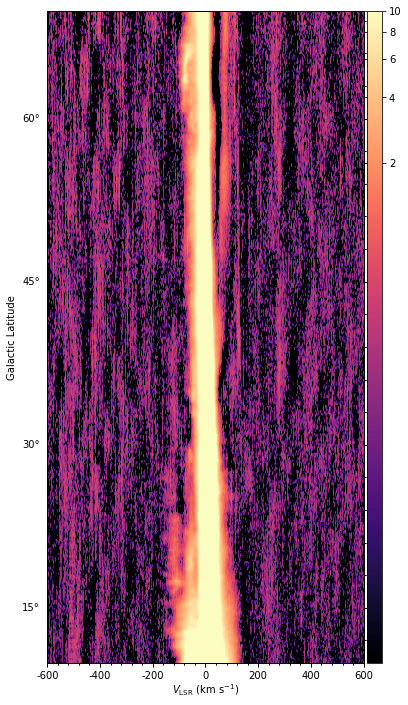

In [42]:
fig = plt.figure(figsize=(6, 12))
f = aplpy.FITSFigure(yv_hdu, slices=[0], figure=fig,convention='wells' ,dimensions=[2,1],aspect='auto')
f.show_colorscale(vmin=0.01, vmax=10.0, aspect='auto', stretch="log", cmap="magma")
gca = plt.gca()
gca.tick_params(axis=0,# vyの場合は0
               labelbottom=False,
               labelleft=False,
               labelright=False,
               labeltop=False,
               bottom=False,
               left=False,
               right=False,
               top=False)
f.add_colorbar()
f.axis_labels.set_xtext("$V_{\mathrm {LSR}}$ (km s$^{-1}$)")
f.axis_labels.set_ytext("Galactic Latitude")

f.tick_labels.set_yposition("left")


plt.show()

In [43]:
z_start,z_end = 350 ,500


new_data = yv_hdu.data[z_start:z_end,:,:]
new_header = yv_hdu.header
new_header["NAXIS3"] = new_data.shape[0]
new_header["CRVAL3"] = int(w.wcs_pix2world(0,0,z_start+(z_end-z_start)/2,0)[2])
new_header["CRPIX3"] = new_data.shape[0]/2
new_hdu = fits.PrimaryHDU(new_data,new_header)

INFO: Setting slices=[0] [aplpy.core]


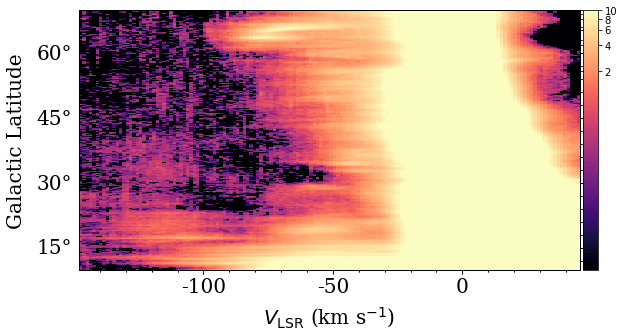

In [44]:
fig = plt.figure(figsize=(12, 6))
f = aplpy.FITSFigure(new_hdu, slices=[0], figure=fig, convention='wells', dimensions=[2, 1], aspect='auto',subplot=[0.1,0.1,0.6,0.6])
f.show_colorscale(vmin=0.01, vmax=10.0, aspect='auto', stretch="log", cmap="magma")

gca = plt.gca()
gca.tick_params(axis=0,# vyの場合は0
               labelbottom=False,
               labelleft=False,
               labelright=False,
               labeltop=False,
               bottom=False,
               left=False,
               right=False,
               top=False)
f.add_colorbar()
f.axis_labels.set_xtext("$V_{\mathrm {LSR}}$ (km s$^{-1}$)")
f.axis_labels.set_ytext("Galactic Latitude")
f.tick_labels.set_yposition("left")
f.tick_labels.set_font(size=20, family='serif')
f.axis_labels.set_font(size=20, family='serif')

# f.tick_labels.hide_x()
# f.axis_labels.hide_x()
# f.show_contour(new_hdu,levels=[20, 25, 30, 35, 40, 45, 50], convention='wells', colors=["w"], slices=[0], dimensions=[2, 1], linewidths=[1,2,2,2,2,2,2,2])
plt.show()

INFO: Setting slices=[0] [aplpy.core]


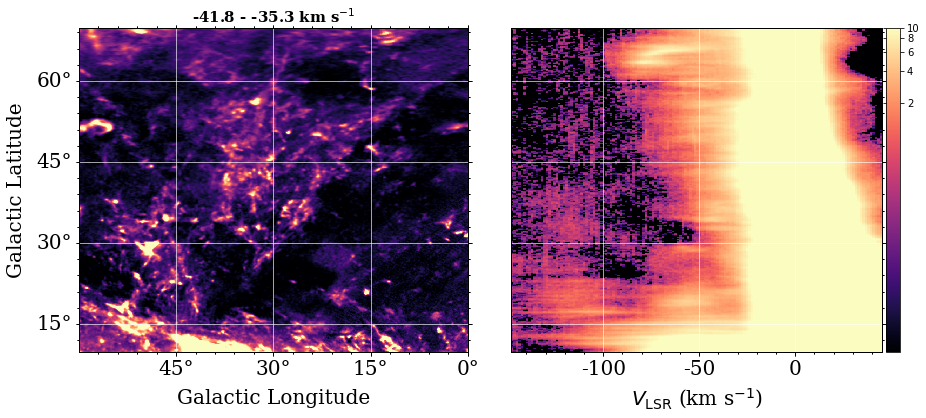

In [56]:
fig = plt.figure(figsize=(12, 6))
f2 = aplpy.FITSFigure(new_hdu, slices=[0], figure=fig, convention='wells', dimensions=[2, 1], aspect='auto',subplot = [0.5,0,0.45,0.75])
f2.show_colorscale(vmin=0.01, vmax=10.0, aspect='auto', stretch="log", cmap="magma")

gca = plt.gca()
gca.tick_params(axis=0,# vyの場合は0
               labelbottom=False,
               labelleft=False,
               labelright=False,
               labeltop=False,
               bottom=False,
               left=False,
               right=False,
               top=False)
f2.add_colorbar()
f2.axis_labels.set_xtext("$V_{\mathrm {LSR}}$ (km s$^{-1}$)")
f2.axis_labels.set_ytext("Galactic Latitude")
f2.tick_labels.set_yposition("left")

f2.tick_labels.hide_y()
f2.axis_labels.hide_y()
# f2.add_label(0,55,-23,"l: 45deg~65deg")

f2.add_grid()
f2.grid.set_color("w")
f2.tick_labels.set_font(size=20, family='serif')
f2.axis_labels.set_font(size=20, family='serif')
# f.show_contour(new_hdu,levels=[20, 25, 30, 35, 40, 45, 50], convention='wells', colors=["w"], slices=[0], dimensions=[2, 1], linewidths=[1,2,2,2,2,2,2,2])

f1 = aplpy.FITSFigure(integ_hdu,figure = fig,slices=[430],subplot = [0,0,0.45,0.75])
f1.show_colorscale(vmin=0,vmax=5,cmap='magma',stretch='linear',exponent=0.5,aspect="auto")
# f.recenter(25,-20,width=25,height=120)
f1.add_grid()
f1.grid.set_color("w")

f1.add_label(pos_added_xlabel,pos_added_ylabel,"%.1f - %.1f km s$^{-1}$"%(v_label_list[6][0], v_label_list[6][1]), color="k", size=15, family='serif', weight='bold')

f1.tick_labels.set_font(size=20, family='serif')
f1.axis_labels.set_font(size=20, family='serif')
plt.show()

f1.savefig("/home/filament/Documents/gakkai/pv/figure/yv_x_%s_%s_%spng"%(x_right,x_left,fpath.split("/")[5][:-4]))

INFO: Setting slices=[0] [aplpy.core]


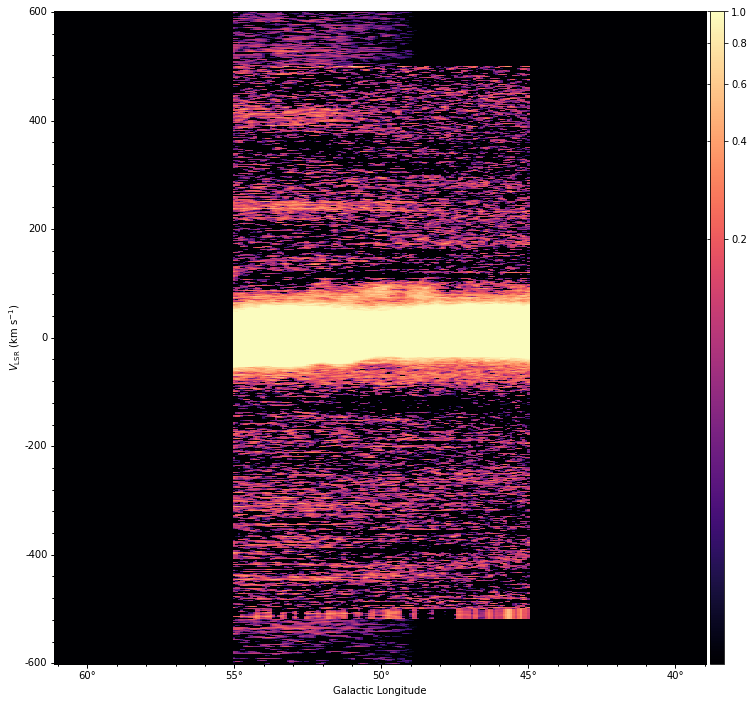

In [332]:
fig = plt.figure(figsize=(12, 12))
f = aplpy.FITSFigure(xv_hdu, slices=[0], figure=fig, convention='wells', dimensions=[0, 2])
f.show_colorscale(vmin=0.01, vmax=1.0, aspect='auto', stretch="log", cmap="magma")
f.add_colorbar()
f.axis_labels.set_xtext("Galactic Longitude")
f.axis_labels.set_ytext("$V_{\mathrm {LSR}}$ (km s$^{-1}$)")

plt.show()

In [333]:
xv_hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  266                                                  
NAXIS2  =                    1                                                  
NAXIS3  =                  933                                                  
OBJECT  = 'HI4PI   '           / The HI 4-PI Survey                             
TELESCOP= 'Effelsberg 100m RT; ATNF Parkes 64-m' / Telescope names              
ORIGIN  = 'AIfA/MPIfR Bonn; ATNF Sydney' / Organisations or Institutions        
REFERENC= 'HI4PI Collaboration 2016' / A&A                                      
RESTFRQ =        1420405751.77                                                  
RESTWAV =       0.211061140541                                                  
WCSAXES =                   

In [334]:
new_data = xv_hdu.data[0:500,:,:]
new_data.shape[0]

500

In [338]:
new_data = xv_hdu.data[400:466,:,:]
new_header = xv_hdu.header
new_header["NAXIS3"] = new_data.shape[0]
new_header["CRVAL3"] = int(w.wcs_pix2world(0,0,433,0)[2])
new_header["CRPIX3"] = new_data.shape[0]/2
new_hdu = fits.PrimaryHDU(new_data,new_header)

INFO: Setting slices=[0] [aplpy.core]


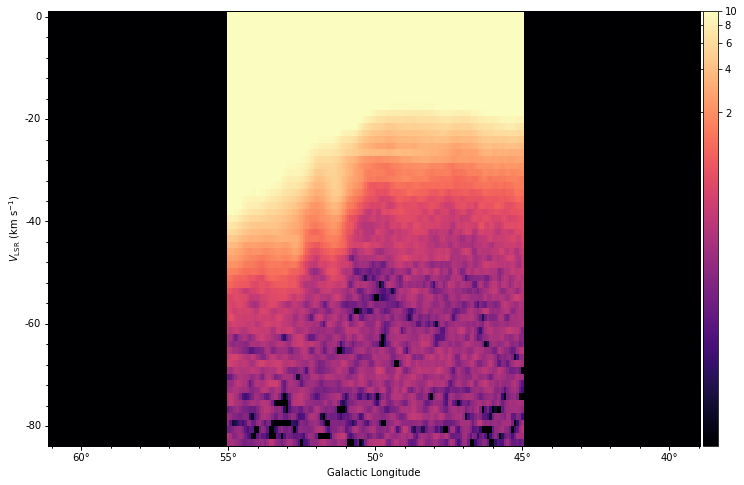

In [339]:
fig = plt.figure(figsize=(12, 8))
f = aplpy.FITSFigure(new_hdu, slices=[0], figure=fig, convention='wells', dimensions=[0, 2])
f.show_colorscale(vmin=0.01, vmax=10.0, aspect='auto', stretch="log", cmap="magma")
f.add_colorbar()
f.axis_labels.set_xtext("Galactic Longitude")
f.axis_labels.set_ytext("$V_{\mathrm {LSR}}$ (km s$^{-1}$)")

plt.show()

In [284]:
new_hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  266                                                  
NAXIS2  =                    1                                                  
NAXIS3  =                  500                                                  
OBJECT  = 'HI4PI   '           / The HI 4-PI Survey                             
TELESCOP= 'Effelsberg 100m RT; ATNF Parkes 64-m' / Telescope names              
ORIGIN  = 'AIfA/MPIfR Bonn; ATNF Sydney' / Organisations or Institutions        
REFERENC= 'HI4PI Collaboration 2016' / A&A                                      
RESTFRQ =        1420405751.77                                                  
RESTWAV =       0.211061140541                                                  
WCSAXES =                   

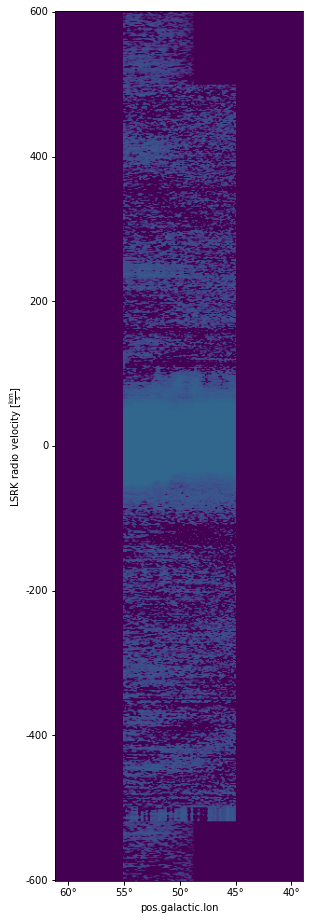

In [216]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
ax = plt.subplot(projection=w, slices=("x", 0, "y"))
ax.coords[2].set_ticklabel(exclude_overlapping=True)
# ax.imshow(xv_hdu.data[234:468,0,67:200].transpose(),vmin=0,vmax =3)
ax.imshow(LogStretch().__call__(xv_hdu.data[:,0,:]),vmin=0.01,vmax =3,origin="lower")
# ax.imshow(yv_hdu.data[:,:,0].transpose())

In [217]:
# from astropy.visualization import LogStretch
from astropy.visualization import AsymmetricPercentileInterval, simple_norm

In [219]:
normalizer = simple_norm(xv_hdu.data[:,0,:], stretch="log")

In [224]:
plt.imshow(normalizer.)

AttributeError: 'ImageNormalize' object has no attribute 'value'

INFO: Setting slices=[0] [aplpy.core]


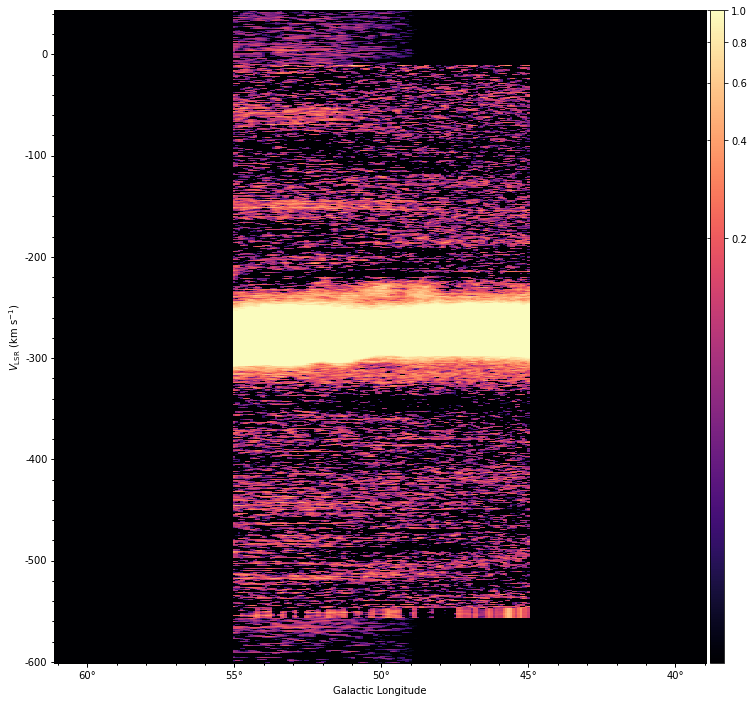

In [258]:
fig = plt.figure(figsize=(12, 12))
f = aplpy.FITSFigure(xv_hdu, slices=[0], figure=fig, convention='wells', dimensions=[0, 2])
f.show_colorscale(vmin=0.01, vmax=1.0, aspect='auto', stretch="log", cmap="magma")
f.add_colorbar()
f.axis_labels.set_xtext("Galactic Longitude")
f.axis_labels.set_ytext("$V_{\mathrm {LSR}}$ (km s$^{-1}$)")

plt.show()

INFO: Setting slices=[0] [aplpy.core]


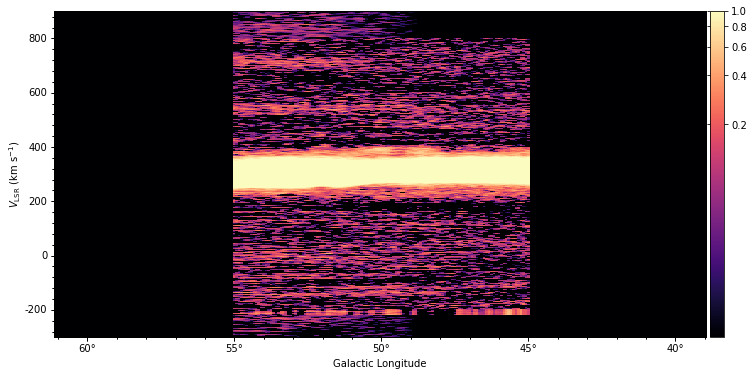

In [145]:
fig = plt.figure(figsize=(12, 6))
f = aplpy.FITSFigure(new_fits, slices=[0], figure=fig, convention='wells', dimensions=[0, 2])
f.show_colorscale(vmin=0.01, vmax=1.0, aspect='auto', stretch="log", cmap="magma")
f.add_colorbar()
f.axis_labels.set_xtext("Galactic Longitude")
f.axis_labels.set_ytext("$V_{\mathrm {LSR}}$ (km s$^{-1}$)")

plt.show()

INFO: Setting slices=[0] [aplpy.core]


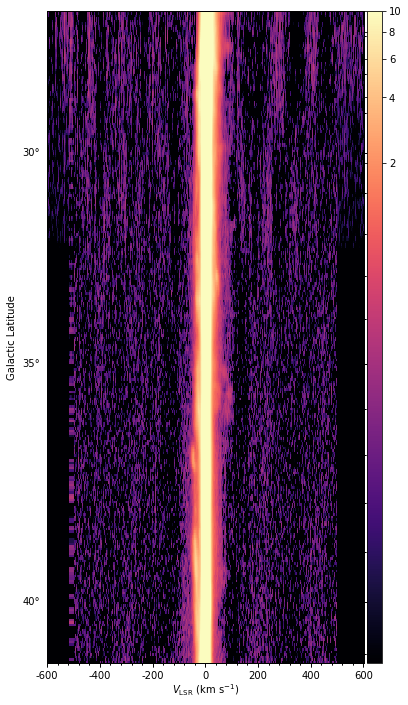

In [105]:
fig = plt.figure(figsize=(6, 12))
f = aplpy.FITSFigure(yv_hdu, slices=[0], figure=fig, convention='wells', dimensions=[2, 1], aspect='auto')
f.show_colorscale(vmin=0.01, vmax=10.0, aspect='auto', stretch="log", cmap="magma")
f.add_colorbar()
f.axis_labels.set_xtext("$V_{\mathrm {LSR}}$ (km s$^{-1}$)")
f.axis_labels.set_ytext("Galactic Latitude")
f.tick_labels.set_yposition("left")
plt.show()

In [61]:
w = WCS(xv_hdu)

In [63]:
a = w.wcs_pix2world(0,0,0,0)
a

[array(61.08333333), array(-51.), array(-600.20721821)]

In [79]:
x,y = 0,0
radius = 10
w = WCS(xv_hdu.header, relax=True)
nx, ny = Image.open(xv_hdu.data[:,0,:].data).size
xpix, ypix,zpix = w.wcs_world2pix(x, y,0,0)

pix_scale = proj_plane_pixel_scales(w)
sx, sy = pix_scale[x], pix_scale[y]

if radius:
    dx_pix = radius / sx
    dy_pix = radius / sy
elif width and height:
    dx_pix = width / sx * 0.5
    dy_pix = height / sy * 0.5
else:
    raise Exception("Need to specify either radius= or width= and height= arguments")

if (xpix + dx_pix < -0.5 or
    xpix - dx_pix > nx - 0.5 or
    ypix + dy_pix < -0.5 or
        ypix - dy_pix > ny):

    raise Exception("Zoom region falls outside the image")

self.ax.set_xlim(xpix - dx_pix, xpix + dx_pix)
self.ax.set_ylim(ypix - dy_pix, ypix + dy_pix)

AttributeError: 'memoryview' object has no attribute 'read'

In [80]:
xv_hdu.data[:,0,:].shape

(933, 266)

/home/filament/.pyenv/versions/3.7.11/envs/fil_project/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/filament/.pyenv/versions/3.7.11/envs/fil_project/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


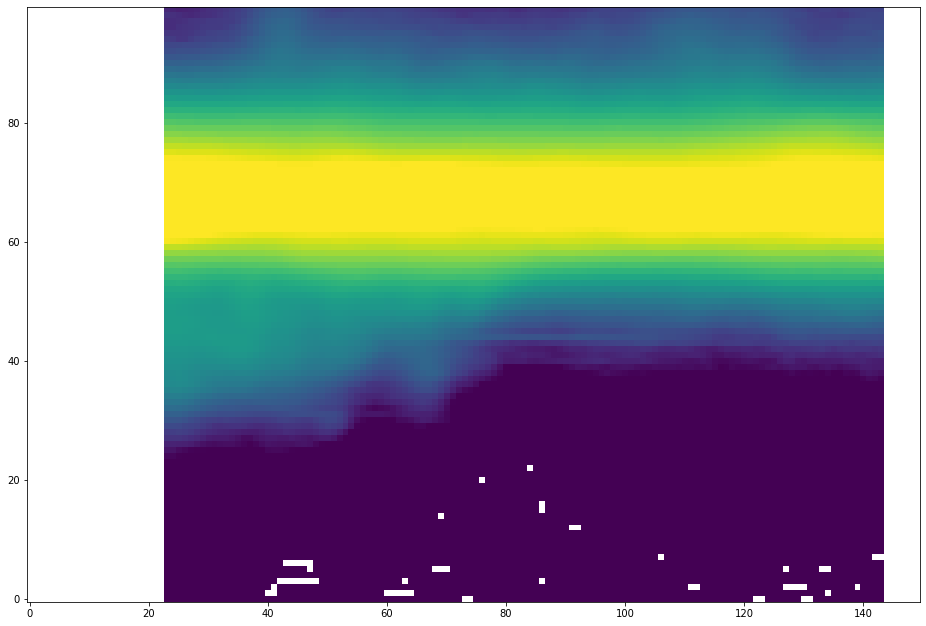

In [88]:
plt.figure(figsize = (16,16))
plt.imshow(np.log(xv_hdu.data[400:500,0,50:200]),origin="lower",vmin = 0.01 ,vmax=5)

In [23]:
def v2ch(v, w): # v(km/s)をchに変える
    x_tempo, y_tempo, v_tempo   = w.wcs_pix2world(0, 0, 0, 0)
    x_ch, y_ch, v_ch   = w.wcs_world2pix(x_tempo, y_tempo, v*1000.0, 0)
    v_ch = int(round(float(v_ch), 0))
    return v_ch

def del_header_key(header, keys): # headerのkeyを消す
    import copy
    h = copy.deepcopy(header)
    for k in keys:
        try:
            del h[k]
        except:
            pass
    return h
def make_new_hdu_integ(hdu, v_start_wcs, v_end_wcs, w): # 積分強度のhduを作る
    data = hdu.data
    header = hdu.header
    start_ch, end_ch = v2ch(v_start_wcs, w), v2ch(v_end_wcs, w)
    new_data = np.nansum(data[start_ch:end_ch+1], axis=0)*np.abs(header["CDELT3"])/1000.0
    header = del_header_key(header, ["CRVAL3", "CRPIX3", "CRVAL3", "CDELT3", "CUNIT3", "CTYPE3", "CROTA3", "NAXIS3", "PC1_3", "PC2_3", "PC3_3", "PC3_1", "PC3_2"])
    header["NAXIS"] = 2
    new_hdu = fits.PrimaryHDU(new_data, header)
    return new_hdu

In [47]:
new_header = xv_hdu.header
new_header["NAXIS2"] = new_header["NAXIS3"]
new_header["CTYPE2"] = new_header["CTYPE3"]
new_header["CUNIT2"] = new_header["CUNIT3"]
new_header["CDELT2"] = new_header["CDELT3"]
new_header["CRPIX2"] = new_header["CRPIX3"]
new_header["CRVAL2"] = new_header["CRVAL3"]
new_header["NAXIS"] = 2
new_header["WCSAXES"] = 2


new_header = del_header_key(new_header, ["NAXIS3","CTYPE3","CUNIT3","CDELT3","CRPIX3","CRVAL3"])

In [38]:
# new_header = xv_hdu.header

# new_header["NAXIS"] = 2
# new_header["WCSAXES"] = 2
# new_header = del_header_key(new_header, ["NAXIS2","CTYPE2","CUNIT2","CDELT2","CRPIX2","CRVAL2"])

In [48]:
new_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  266                                                  
NAXIS2  =                  933                                                  
OBJECT  = 'HI4PI   '           / The HI 4-PI Survey                             
TELESCOP= 'Effelsberg 100m RT; ATNF Parkes 64-m' / Telescope names              
ORIGIN  = 'AIfA/MPIfR Bonn; ATNF Sydney' / Organisations or Institutions        
REFERENC= 'HI4PI Collaboration 2016' / A&A                                      
RESTFRQ =        1420405751.77                                                  
RESTWAV =       0.211061140541                                                  
WCSAXES =                    2                                                  
CDELT1  = -0.083333333300000

In [49]:
xv_hdu.data[:,0,:].transpose().shape

(266, 933)

In [50]:
ii_xv_hdu = fits.PrimaryHDU(xv_hdu.data[:,0,:],new_header)

In [51]:
ii_xv_hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  266                                                  
NAXIS2  =                  933                                                  
OBJECT  = 'HI4PI   '           / The HI 4-PI Survey                             
TELESCOP= 'Effelsberg 100m RT; ATNF Parkes 64-m' / Telescope names              
ORIGIN  = 'AIfA/MPIfR Bonn; ATNF Sydney' / Organisations or Institutions        
REFERENC= 'HI4PI Collaboration 2016' / A&A                                      
RESTFRQ =        1420405751.77                                                  
RESTWAV =       0.211061140541                                                  
WCSAXES =                    2                                                  
CDELT1  = -0.083333333300000

In [52]:
fig = plt.figure(figsize=(12, 6))
f = aplpy.FITSFigure(ii_xv_hdu, figure=fig, convention='wells')
f.show_colorscale(vmin=0.01, vmax=10.0, aspect='auto', stretch="log", cmap="magma")
f.add_colorbar()
f.axis_labels.set_xtext("Galactic Longitude")
f.axis_labels.set_ytext("$V_{\mathrm {LSR}}$ (km s$^{-1}$)")

plt.show()

InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3062 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.


<Figure size 864x432 with 0 Axes>